# Figure 3
Example of the flatness check in FLUID.

In [1]:
%matplotlib widget
# %load_ext autoreload
# %autoreload 2
from fig3code import *

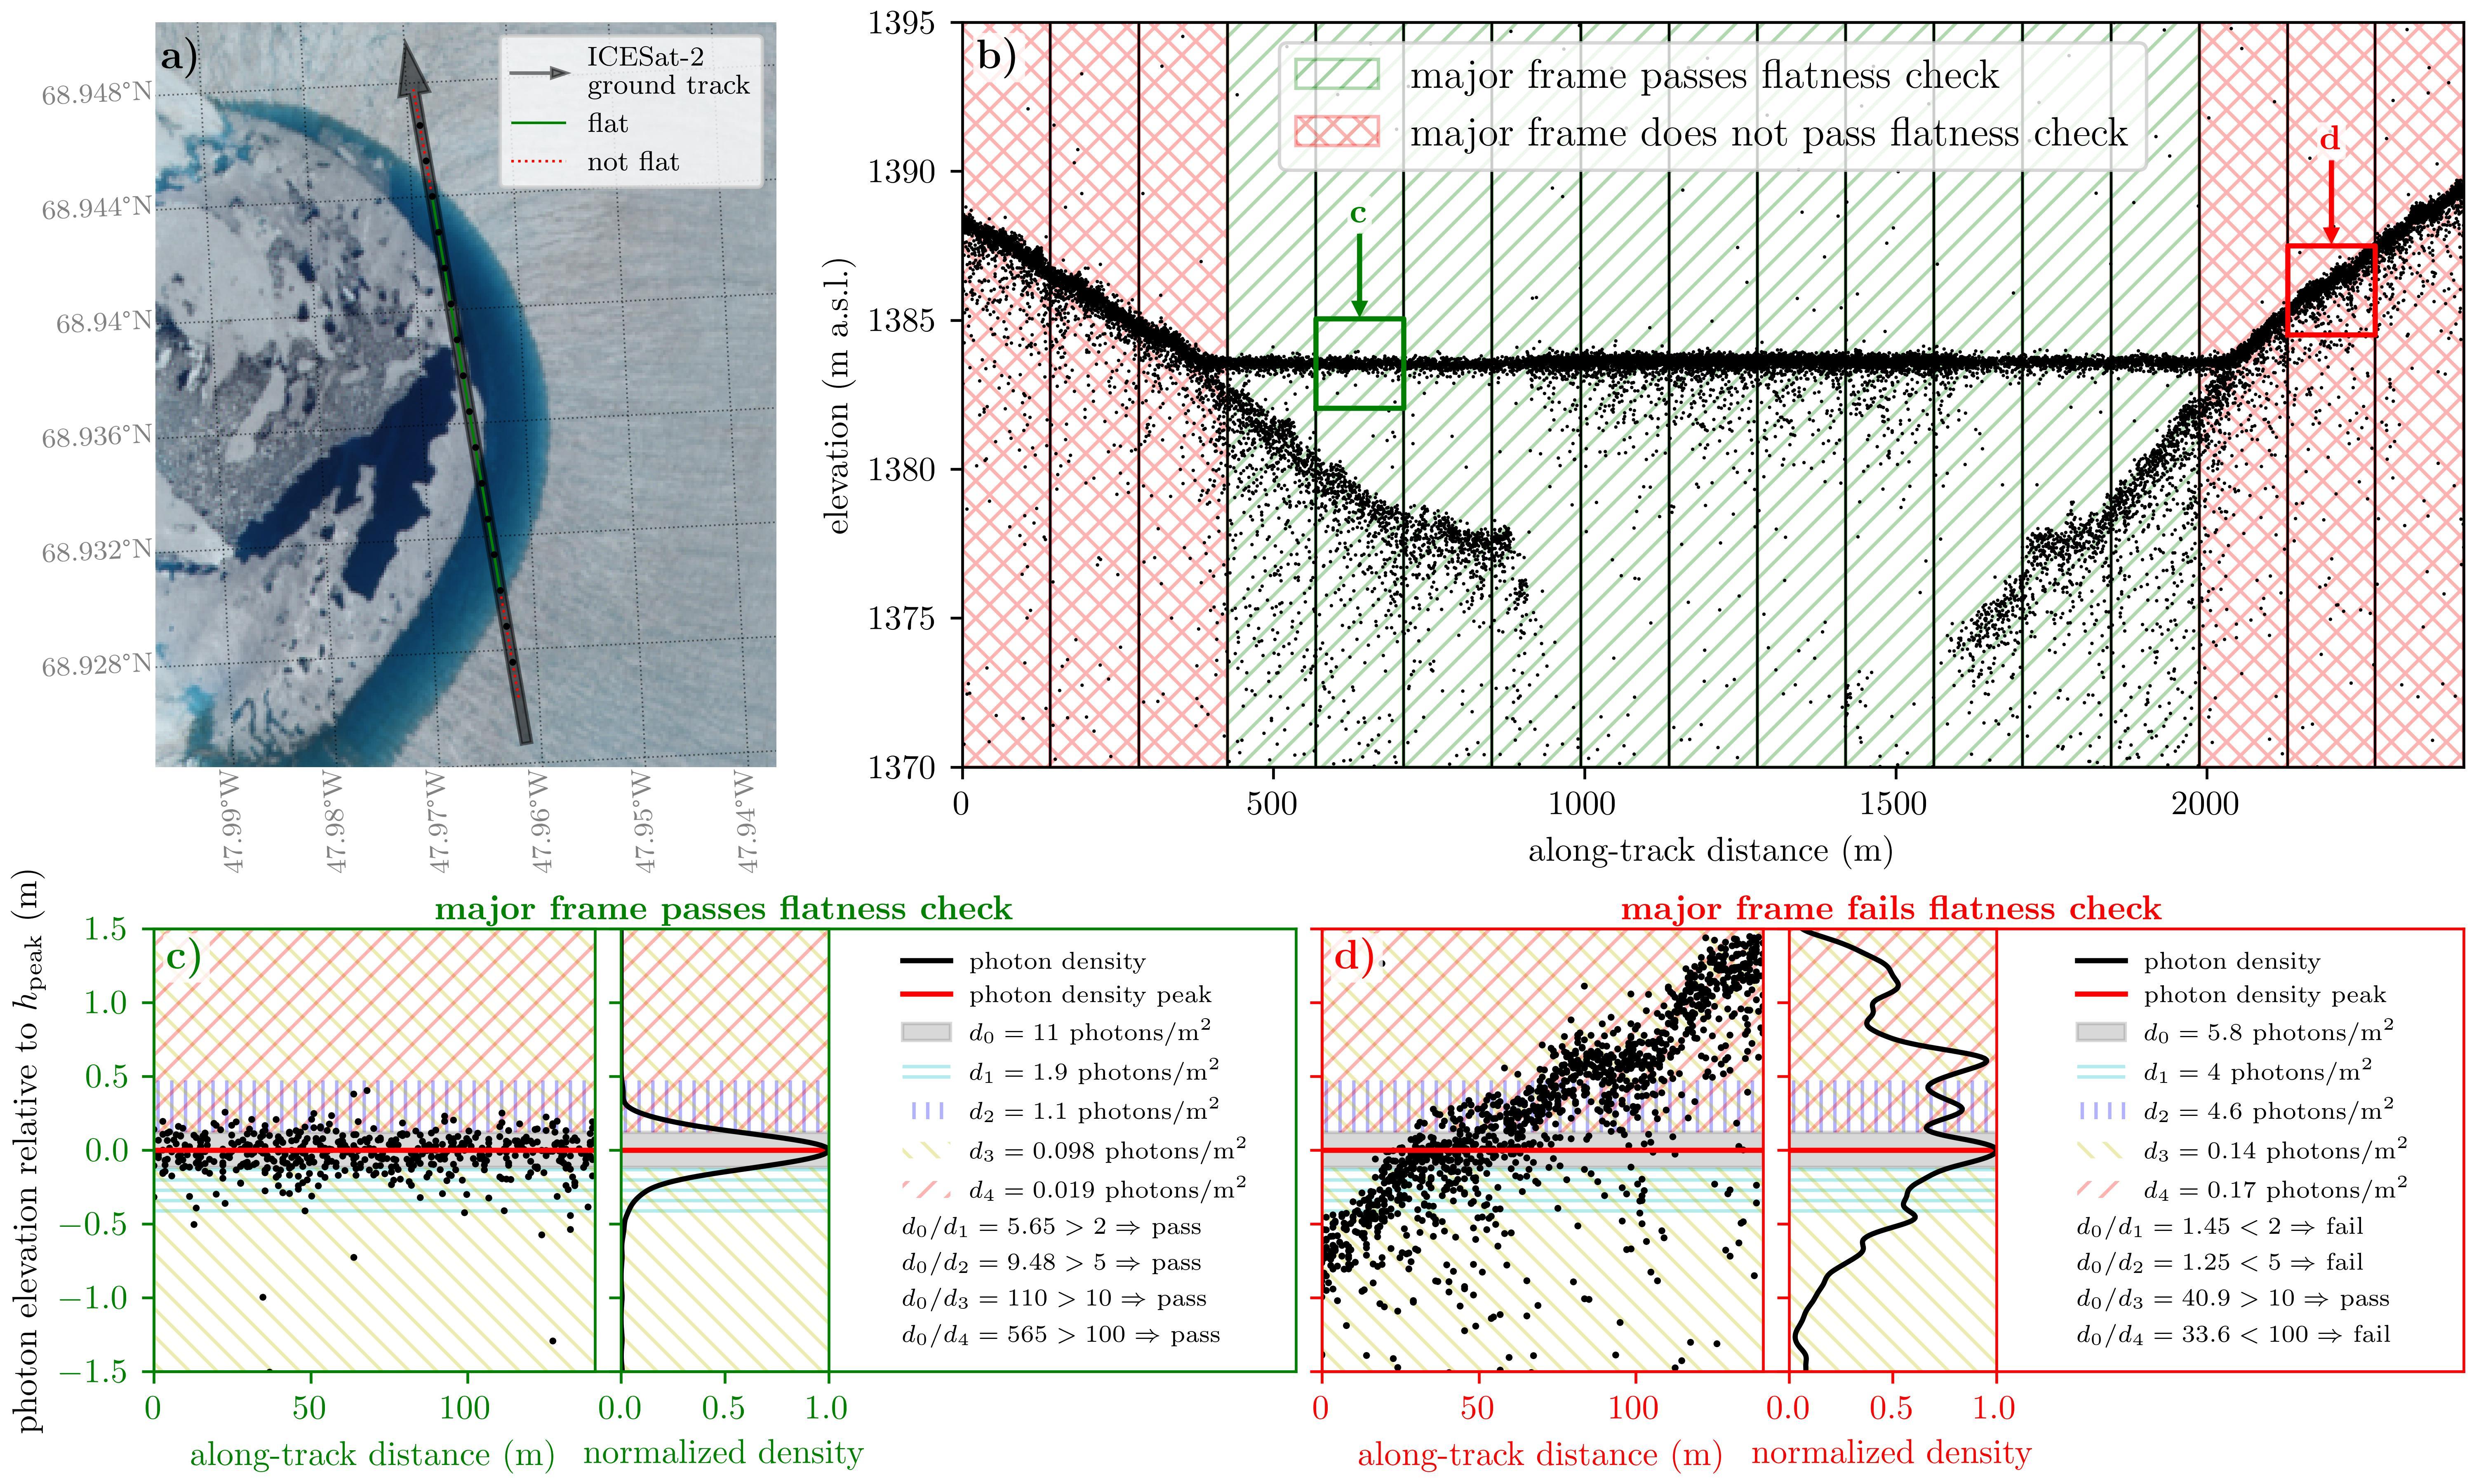


LAKE INFO: 
  granule_id:            ATL03_20190712052659_02160403_006_02.h5
  RGT:                   216
  GTX:                   GT1L
  beam:                  1 (strong)
  acquisition time:      2019-07-12T05:29:26Z
  center location:       (47.96565W, 68.93705N)
  ice sheet:             GrIS
  melt season:           2019
  IMAGERY INFO:
    product ID:                     S2A_MSIL2A_20190713T150921_N0213_R025_T22WFB_20190713T191839
    acquisition time imagery:       2019-07-13T08:13:30Z
    acquisition time ICESat-2:      2019-07-12T05:29:26Z
    time difference from ICESat-2:  1 day, 2:44:04 (1 day after ICESat-2)
    mean cloud probability:         7.9 %



In [2]:
# input data
file = 'data/lake_flatness_check.h5'
imagery_filename = 'data/S2A_MSIL2A_20190713T150921_N0213_R025_T22WFB_20190713T191839.tif'

plotname = '../figures/fig03-flatness_check_imagery.jpg'
re_download_imagery = False # adjust to True to re-download imagery using Google Earth Engine
ylm = (1370, 1395)
indexes_major_frame_panels = (4,15)

# some figure parameters
plt.rcParams.update({
    'font.size': 10,
    'text.usetex': True,
    'font.family': 'Optima',
    'text.latex.preamble': r"\usepackage{amsmath}"
})
boxprops = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='none', pad=0.1)

# read the data from the input lake file
lk = dictobj(read_melt_lake_h5(file))
df = lk.photon_data
dfm = lk.mframe_data

# create figure and axes
fig = plt.figure(figsize=[10, 6], dpi=100)
gs = fig.add_gridspec(ncols=10, nrows=5)
ax0 = fig.add_subplot(gs[:3, :])
ax0.axis('off')
ax1 = ax0.inset_axes([-0.05, 0, 0.37, 1])
ax2 = ax0.inset_axes([0.35, 0, 0.65, 1])
axs = [ax1, ax2]
nrows = 2
for i in np.arange(nrows):
    axs.append(fig.add_subplot(gs[3:, 5*i:5*i+2]))
    if i==0:
        axs[-1].set_ylabel('elevation (m)')
    else:
        plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[3:, 5*i+2], sharey=axs[-1]))
    plt.setp(axs[-1].get_yticklabels(), visible=False)
    axs.append(fig.add_subplot(gs[3:, 5*i+3:5*i+5]))
    axs[-1].axis('off')

####################################################
# plot the photon data for the entire lake (upper right)
ax = axs[1]
ax.scatter(df.xatc, df.h, s=1, alpha=1, facecolors='k', edgecolors='none')

# plot the major frame boundaries as black vertical lines
lns = []
for i in range(len(dfm)-1):
    ln = (dfm.iloc[i].xatc_max + dfm.iloc[i+1].xatc_min) / 2
    ax.plot([ln]*2, ylm, 'k-', lw=0.7)
    lns.append(ln)

# indicate whether the flatness check passed by hatching major frames
# is_flat_list = run_flatness_checks(file) # to re-run the flatness check
is_flat_list = list(dfm.is_flat)
bounds = [df.xatc.min()] + lns + [df.xatc.max()]
hdls = [0, 0]
for i, is_flat in enumerate(is_flat_list):
    thiscol = 'g' if is_flat else 'r'
    thishatch = '///' if is_flat else 'XXX'
    label = 'major frame passes flatness check' if is_flat else 'major frame does not pass flatness check'
    j = 0 if is_flat else 1
    hdl = ax.fill_between([bounds[i], bounds[i+1]], ylm[0], ylm[1], facecolor="none", hatch=thishatch, edgecolor=thiscol, 
                                linewidth=1, alpha=0.3, label=label, zorder=-100)
    hdls[j] = hdl

# place the legend for passing/failing hatching
ax.legend(handles=hdls, loc='upper center', fontsize=12)
ax.set_xlim((df.xatc.min(), df.xatc.max()))
ax.set_ylim(ylm)
ax.set_xlabel('along-track distance (m)')
ax.set_ylabel('elevation (m a.s.l.)')

####################################################
# plot the passing major frame zoom-in (lower left)
ax_color = 'g'
imf = indexes_major_frame_panels[0]
yl = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[2:5], ax_color=ax_color, ax_lab='c)', plot=True, normalize_to_zero=True,
                            legendtitle=False)[0]
# plot the location of the major frame zoom-in on the figure of the whole lake
axs[1].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{c}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='g', bbox=boxprops,
            arrowprops=dict(facecolor='g', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))
axs[2].set_ylabel(r'photon elevation relative to $h_\text{peak}$ (m)', color='k')

# draw a boundary around the subplots for the passing major frame zoom-in
axpass = fig.add_subplot(gs[3:, :5])
axpass.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
axpass.patch.set_facecolor('none')
set_axis_color(axpass, 'green')
axpass.text(0.5, 1.02, r'\textbf{major frame passes flatness check}', ha='center', transform=axpass.transAxes, color='green')

####################################################
# plot the failing major frame zoom-in (lower right)
ax_color = 'r'
imf = indexes_major_frame_panels[1]
yl = flatness_check(imf=imf, df=df, dfm=dfm, axs=axs[5:8], ax_color=ax_color, ax_lab='d)', plot=True, normalize_to_zero=True,
                            legendtitle=False)[0]
# plot the location of the major frame zoom-in on the figure of the whole lake
axs[1].plot([lns[i] for i in [imf-1,imf, imf, imf-1, imf-1]], [yl[i] for i in [0,0,1,1,0]], c=ax_color)
xarr = (lns[imf]+lns[imf-1])/2
ax.annotate(r'\textbf{d}', xy=(xarr, yl[1]), xytext=(xarr, yl[1]+3), ha='center', va='bottom', color='r', bbox=boxprops,
            arrowprops=dict(facecolor='r', shrink=0.01, width=1.5, headwidth=5, headlength=5, edgecolor='none'))

# draw a boundary around the subplots for the failing major frame zoom-in
axfail = fig.add_subplot(gs[3:, 5:])
axfail.tick_params(bottom=False,left=False,labelbottom=False,labelleft=False)
axfail.patch.set_facecolor('none')
set_axis_color(axfail, 'red')
axfail.text(0.5, 1.02, r'\textbf{major frame fails flatness check}', ha='center', transform=axfail.transAxes, color='red')

####################################################
# add imagery (upper left)
img_aspect=1.2
ax = axs[0]
ax.axis('off')

img, center_lon, center_lat = plot_imagery(fn=file, days_buffer=5, max_cloud_prob=15, xlm=[None, None], ylm=[None, None], 
    gamma_value=1.0, imagery_filename=imagery_filename, re_download=re_download_imagery, ax=ax)

# add legend to imagery
hdl_arr, hdls_ext = add_gt_to_imagery(file, img, ax, arrow_width=40, arrow_col=(0,0,0,0.5), arrow_ls='-', line_col='r', 
    arrow_label='ICESat-2\nground track', line_width=0.75, bounds=bounds, passing_list=is_flat_list, arrow_extend=0.15)
ax.legend(handles=[hdl_arr]+hdls_ext, loc='upper right', fontsize=8,
          handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow)})

# adjust imagery aspect ratio in plot
if (img_aspect > 1): 
    h_rng = img.bounds.top - img.bounds.bottom
    cntr = (img.bounds.right + img.bounds.left) / 2
    ax.set_xlim(cntr-0.5*h_rng/img_aspect, cntr+0.5*h_rng/img_aspect)
elif img_aspect < 1: 
    w_rng = img.bounds.right - img.bounds.left
    cntr = (img.bounds.top + img.bounds.bottom) / 2
    ax.set_ylim(cntr-0.5*w_rng*img_aspect, cntr+0.5*w_rng/img_aspect)

# add graticule to imagery
add_graticule(img, ax)

# add panel labels
axs[0].text(0.01, 0.98, r'\textbf{a)}', transform=axs[0].transAxes, color='k', ha='left', va='top', fontsize=12)
axs[1].text(0.01, 0.98, r'\textbf{b)}', transform=axs[1].transAxes, color='k', ha='left', va='top', fontsize=12, bbox=boxprops)
gs.tight_layout(fig, pad=0.3, w_pad=0.3)

# save file
fig.savefig(plotname , dpi=600)
plt.close(fig)

# show plot and print info
display(Image(plotname))
print_lake_info(file)
major_frame_info_flatness_check = get_major_frame_level_info(dfm)

## flatness check results for all major frames

In [3]:
major_frame_info_flatness_check

,idx,is_flat,peak,xatc,d_0,d_1,d_2,d_3,d_4,r_0,r_1,r_2,r_3
mframe,,,,,,,,,,,,,
40720826,0,False,1387.9,70.6,5.94,5.06,3.48,0.139,0.0573,1.17,1.7,42.6,104
40720827,1,False,1385.1,212.5,5.19,2.67,4.61,0.148,0.261,1.94,1.13,35,19.9
40720828,2,False,1383.5,354.8,8.9,1.59,4.57,0.144,0.213,5.59,1.95,61.7,41.8
40720829,3,True,1383.5,496.9,10.7,1.86,1.84,0.12,0.0252,5.77,5.83,89.8,427
40720830,4,True,1383.5,638.4,10.8,1.91,1.14,0.0976,0.0191,5.65,9.48,110,565
40720831,5,True,1383.5,780.1,8.48,1.96,1.13,0.101,0.0207,4.33,7.5,84.1,410
40720832,6,True,1383.6,922.2,14.5,3.43,2.65,0.0766,0.0389,4.23,5.48,190,373
40720833,7,True,1383.6,1064.7,21.1,5.17,3.11,0.0762,0.0436,4.08,6.79,277,485
40720834,8,True,1383.6,1206.7,20.4,5.74,3.42,0.0815,0.0484,3.56,5.98,251,422
